# DAT102x: Predicting Evictions

## Prepare environment

In [58]:
## Normally only the last output in the cell gets pretty printed - the rest you have to manually add print() which is not very convenient. 
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

%load_ext skip_kernel_extension

In [3]:
## Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import time

import numpy as np
import pandas as pd

######################################## PLOTTING ########################################
## Note that the implementation of the plot() method in pandas is based on matplotlib.

### MATPLOTLIB (https://matplotlib.org/index.html)
## We will display plots right inside Jupyter Notebook
%matplotlib inline
import matplotlib.pyplot as plt

### SEABORN (https://seaborn.pydata.org/introduction.html)
### SEABORN is essentially a higher-level API based on the matplotlib library. 
import seaborn as sns
sns.set() # sns.set(color_codes=True)
## Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

## Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

### PLOTLY (https://plot.ly/python/)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

##########################################################################################
from scipy import stats

## Utility Functions

In [4]:
def print_df_shape(dfs):
    for name, df in dfs:
        print('{0} data has {1} rows and {2} columns.'.format(name, df.shape[0], df.shape[1]), '\n')

def roundti(val):
    return int(round(val))

# Returns the list of column names with NaN values
def get_cols_w_missing_data(df, verbose = True):
    result = df.isnull().sum()[lambda x: x > 0]
    if verbose:
        print('Columns with missing data:\n\n', result, sep='')

    return result, list(result.index)

def gen_groupby(df, col_name, agg_fn, grpby_col_names = ''):
    if (grpby_col_names == '') | (len(grpby_col_names) == 0):
        df = df.agg({col_name: [agg_fn]})
    else:
        df = df.groupby(grpby_col_names).agg({col_name: agg_fn})
    return df

## Filling missing values
def gen_fillna(df, col_name, agg_fn, grpby_col_names = '', round_to_int = False):
    df_agg = gen_groupby(df, col_name, agg_fn, grpby_col_names)
    
    if (grpby_col_names == '') | (len(grpby_col_names) == 0):
        agg_val = df_agg.iloc[0,0]
        #df[col_name] = df[col_name].fillna(agg_val)
        df[col_name].fillna(agg_val, inplace=True)
    else:
        if isinstance(grpby_col_names, str):
            grpby_col_names = [grpby_col_names]
            
        if len(grpby_col_names) == 1:
            for ndx, row in df_agg.iterrows():
                agg_val = row[col_name]
                if round_to_int == True:
                    agg_val = round(agg_val)

                df.loc[df[grpby_col_names[0]] == ndx, col_name] = df.loc[df[grpby_col_names[0]] == ndx, col_name].fillna(agg_val)
        elif len(grpby_col_names) == 2:
            for ndx, row in df_agg.iterrows():
                agg_val = row[col_name]
                if round_to_int == True:
                    agg_val = round(agg_val)
                
                df_nan_rows = df.loc[(df[grpby_col_names[0]] == ndx[0]) & (df[grpby_col_names[1]] == ndx[1]), col_name].isnull()[lambda x: x > 0]
                if (len(df_nan_rows) > 0):
                    df.loc[df_nan_rows.index, col_name] = agg_val
                    
    return df

##### Detecting and handling outliers

## Replacing invalid percent values
def replace_perc_values_outliers(df, col_name, lower_val = 0, upper_val = 100):
    lower_outliers = df[col_name] < 0
    upper_outliers = df[col_name] > 100
    
    print('Count of outliers of "{0}", lower = {1}, upper = {2}"'.format(col_name, str(lower_outliers.sum()), str(upper_outliers.sum())))
    
    if lower_outliers.sum() > 0:
        df.loc[lower_outliers, col_name] = lower_val

    if upper_outliers.sum() > 0:
        df.loc[upper_outliers, col_name] = upper_val

## Detecting outliers using IQR method
def detect_iqr_outliers(srs, replace = False, verbose = True):
    quantile_1, quantile_3 = srs.quantile([0.25, 0.75])
    iqr = quantile_3 - quantile_1
    lower_bound = quantile_1 - (iqr * 1.5)
    upper_bound = quantile_3 + (iqr * 1.5)
    #print('lower_bound: {0}, upper_bound: {1}, IQR: {2}, quantile_1: {3}, quantile_3: {4}'.format(round(lower_bound, 1), round(upper_bound, 1), round(iqr, 1), round(quantile_1, 1), round(quantile_3, 1)))
    #print('lower_bound: {0}, upper_bound: {1}, IQR: {2}'.format(round(lower_bound, 1), round(upper_bound, 1), round(iqr, 1)))
    
    result = srs[(srs > upper_bound) | (srs < lower_bound)]
    if verbose:
        print(srs.name, 'outlier count:', len(result))
    
    if (replace == True):
        srs[srs < lower_bound] = quantile_1
        srs[srs > upper_bound] = quantile_3
        return srs
    else:
        return result

## Replacing\Removing outliers using IQR method
def handle_iqr_outliers(df, col_list = [], replace = True):
    if len(col_list) == 0:
        col_list = df.select_dtypes(include=[np.number]).columns.tolist()
    
    out_ndxs = pd.Index([])
    for col_name in col_list:
        if (replace == True):
            df[col_name] = detect_iqr_outliers(df[col_name].copy(), True)
        else:
            out_ndxs = out_ndxs.append(detect_iqr_outliers(df[col_name]).index)

    if (replace == False):
        out_ndxs = out_ndxs.drop_duplicates()
        df.drop(out_ndxs, inplace=True)
        
    return df

## Detecting outliers using MAD (Median Absolute Deviation)
## https://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def detect_mad_outliers(srs, thresh = 3.5, verbose = True):
    median = srs.median()
    diff = (srs - median) ** 2
    diff = diff.pow(0.5)
    med_abs_deviation = diff.median()
    
    modified_z_score = 0.6745 * diff / med_abs_deviation
    result = srs[modified_z_score > thresh]
    
    if verbose:
        print(srs.name, 'outlier count:', len(result))
    return result


## Load Data

In [5]:
df_train_x = pd.read_csv('../input/train_values.csv')
df_train_y = pd.read_csv('../input/train_labels.csv')

df_train = pd.merge(df_train_x, df_train_y, on="row_id", how="inner")

del df_train_x, df_train_y

y_label = 'evictions'

df_score = pd.read_csv('../input/test_values.csv')
df_score[y_label] = -1

## Exploratory Analysis

In [6]:
print_df_shape(zip(['Training', 'Score'], [df_train, df_score]))

df_train.head()

Training data has 2546 rows and 49 columns. 

Score data has 2420 rows and 49 columns. 



,row_id,county_code,year,state,population,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,...,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,evictions
0,0,a4e2211,b,d725a95,45009.0,6944.0,37.218,643.0,33315.0,98494.0,...,0.532,0.252,0.153,0.233000,0.375000,0.278000,0.114000,12.915129,11.205112,681
1,1,583e0c7,a,533155c,9872.0,1224.0,31.773,517.0,43724.0,85444.0,...,0.509,0.252,0.188,0.073293,0.397590,0.331325,0.197791,11.049159,12.276843,0
2,2,4776bfd,b,d725a95,17625.0,1725.0,21.973,671.0,37777.0,136162.0,...,0.451,0.166,0.189,0.206587,0.303393,0.301397,0.188623,7.903576,10.161741,29
3,3,97fb48d,a,d725a95,134136.0,18180.0,36.809,603.0,30607.0,70062.0,...,0.519,0.263,0.125,0.248255,0.334995,0.290130,0.126620,13.137119,10.202072,841
4,4,47a9ba3,a,be99678,6936.0,551.0,17.627,668.0,44237.0,187066.0,...,0.487,0.196,0.203,0.058648,0.276342,0.413519,0.251491,6.084752,5.939877,2


This will tell us the `total number of non null observations` present including the `total number of entries`. Once number of entries isn’t equal to number of non null observations, we can begin to suspect **missing values**.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2546 entries, 0 to 2545
Data columns (total 49 columns):
row_id                                        2546 non-null int64
county_code                                   2546 non-null object
year                                          2546 non-null object
state                                         2546 non-null object
population                                    2546 non-null float64
renter_occupied_households                    2546 non-null float64
pct_renter_occupied                           2546 non-null float64
median_gross_rent                             2546 non-null float64
median_household_income                       2544 non-null float64
median_property_value                         2544 non-null float64
rent_burden                                   2546 non-null float64
pct_white                                     2546 non-null float64
pct_af_am                                     2546 non-null float64
pct_hispanic  

In [8]:
id_col = 'row_id'
id_cols = ['row_id', 'county_code', 'year', 'state']

# print statistics of numerical features (int64 and float64 types)
df_train.describe()

,row_id,population,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,...,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,evictions
count,2546.000000,2.546000e+03,2546.000000,2546.00000,2546.000000,2544.000000,2544.000000,2546.000000,2546.000000,2546.000000,...,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000
mean,1272.500000,1.062459e+05,15008.009034,28.14739,688.838178,46050.601415,129609.579009,28.520561,0.776272,0.089774,...,0.499126,0.226179,0.171583,0.147891,0.353198,0.300911,0.198000,11.481923,10.407134,378.048311
std,735.111216,3.228520e+05,53333.684235,7.94014,183.722492,11584.627249,76236.606321,4.453165,0.201149,0.145550,...,0.024247,0.032725,0.041928,0.068077,0.070167,0.051811,0.086415,2.565979,2.720135,1405.276610
min,0.000000,1.160000e+02,14.000000,7.30500,336.000000,19328.000000,32287.000000,9.986000,0.050935,0.000000,...,0.285000,0.088000,0.063000,0.016032,0.127127,0.137000,0.018868,3.612183,0.000000,0.000000
25%,636.250000,1.029350e+04,1052.000000,22.88400,577.250000,38495.500000,85288.250000,26.047250,0.655224,0.005669,...,0.495000,0.206000,0.144000,0.097000,0.308732,0.265734,0.138146,9.915292,8.558383,4.000000
50%,1272.500000,2.386300e+04,2580.500000,26.86600,642.000000,44480.000000,108844.000000,28.780000,0.855478,0.021864,...,0.504000,0.225000,0.168000,0.130869,0.356574,0.301301,0.176677,11.306037,10.478088,29.000000
75%,1908.750000,6.796875e+04,8098.750000,32.09275,750.000000,51526.000000,151696.250000,31.160500,0.935331,0.094011,...,0.511000,0.243750,0.194750,0.194410,0.401405,0.336000,0.232908,12.836254,12.159568,160.750000
max,2545.000000,5.279852e+06,882101.000000,70.61000,1728.000000,123452.000000,904937.000000,49.535000,0.995114,0.858997,...,0.572000,0.359000,0.345000,0.465932,0.550349,0.448692,0.584080,28.922868,27.397260,29251.000000


In [9]:
non_num_cols = list(set(df_train.select_dtypes(include=['object', 'bool']).columns) - set(id_cols))

# print statistics on non-numerical features
df_train[non_num_cols].describe()
#df_train[df_train.select_dtypes(include=['object', 'bool']).columns].describe()

,rucc,urban_influence,economic_typology
count,2546,2546,2546
unique,9,12,6
top,"Nonmetro - Urban population of 2,500 to 19,999...",Small-in a metro area with fewer than 1 millio...,Nonspecialized
freq,466,550,1024


## Data Cleanup

In [10]:
## Concat Train and Score sets
df_trsc = pd.concat([df_train, df_score], ignore_index=True, sort=False)

print_df_shape(zip(['Training + Score'], [df_trsc]))

Training + Score data has 4966 rows and 49 columns. 



### Column Manipulations

In [11]:
# DECLARE: Find out if certain columns are unnecessarily floats
df_tmp = df_trsc.copy()
df_tmp.fillna(0, inplace = True)

float_cols = list(df_train.select_dtypes(include=[float]).columns)
# = ['population', 'renter_occupied_households', 'median_gross_rent', 'median_household_income', 'median_property_value']
poss_int_cols_list = []
for col_name in float_cols:
    if np.array_equal(df_tmp[col_name], df_tmp[col_name].astype(int)):
        poss_int_cols_list.append(col_name)
    
print('Following columns are actually integer instead of float:\n', poss_int_cols_list)

Following columns are actually integer instead of float:
 ['population', 'renter_occupied_households', 'median_gross_rent', 'median_household_income', 'median_property_value', 'pop_per_dentist', 'pop_per_primary_care_physician']


### Exploring Missing Data

In [12]:
missing_data, missing_data_cols = get_cols_w_missing_data(df_trsc)

#df_trsc[df_trsc['median_gross_rent'].isnull()]
#df_train[df_train['median_household_income'].isnull()]
#df_train[df_train['median_property_value'].isnull()]
#df_trsc[df_trsc['air_pollution_particulate_matter_value'].isnull()]

Columns with missing data:

median_gross_rent                            2
median_household_income                      2
median_property_value                        2
pct_adult_smoking                          752
pct_low_birthweight                        233
pct_excessive_drinking                    1528
air_pollution_particulate_matter_value       4
homicides_per_100k                        3093
motor_vehicle_crash_deaths_per_100k        580
pop_per_dentist                            353
pop_per_primary_care_physician             318
dtype: int64


### Handling Missing Data
#### A) Case Deletion

##### 1. Remove rows that have 'NA' values more than our 'treshold'

In [13]:
missing_val_treshold = 0.3

print_df_shape(zip(['Training', 'Score'], [df_train, df_score]))

Training data has 2546 rows and 49 columns. 

Score data has 2420 rows and 49 columns. 



In [14]:
train_col_count = df_train.shape[1]

## Apply a count over the rows
train_rows_w_na = train_col_count - df_train.apply(lambda x: x.count(), axis = 1)

## Rows that have any NA and the number of columns with NA (pandas.core.series.Series)
rows_w_too_much_na = train_rows_w_na[(train_rows_w_na / train_col_count > missing_val_treshold)]

print('Number of rows with more than %{0} NA in train data: {1}'.format(str(missing_val_treshold * 100), str(rows_w_too_much_na.count())))

Number of rows with more than %30.0 NA in train data: 0


In [15]:
## Remove rows with more than 30% NA
if (rows_w_too_much_na.count() > 0):
    df_train.drop(rows_w_too_much_na.index, inplace = True, axis = 0)
    print('Training data has {0} rows and {1} columns'.format(df_train.shape[0], df_train.shape[1]))
    
    df_train.head()
else:
    print('NO rows removed: There are NO rows with more than %{0} NA in train data'.format(str(missing_val_treshold * 100)))

NO rows removed: There are NO rows with more than %30.0 NA in train data


##### 2. Remove columns that have 'NA' values more than our 'treshold'  

In [16]:
train_row_count = df_train.shape[0]

## Columns that have any NA and the number of rows with NA (pandas.core.series.Series)
train_cols_w_na = train_row_count - df_train.loc[:, df_train.isnull().any()].count()

cols_w_too_much_na = train_cols_w_na[(train_cols_w_na / train_row_count > missing_val_treshold)]

print('Number of columns with more than %' + str(missing_val_treshold * 100) + ' NA in train data: ' + str(cols_w_too_much_na.count()), 
      cols_w_too_much_na,
      sep='\n\n', end='\n\n')

Number of columns with more than %30.0 NA in train data: 2

pct_excessive_drinking     810
homicides_per_100k        1598
dtype: int64



In [17]:
## Remove columns with more than 30% NA in train data, then drop same columns from score data
if (cols_w_too_much_na.count() > 0):
    df_train.drop(cols_w_too_much_na.keys(), inplace = True, axis = 1)

    ## Drop same columns from score data
    df_score.drop(cols_w_too_much_na.keys(), inplace = True, axis = 1)

In [18]:
### Create dataframe of original obesity and animal_protein values for use in second model 
## after running first model predictions
#df_train_org = df_train[['row_id', 'obesity_prevalence', 'avg_supply_of_protein_of_animal_origin', 'prevalence_of_undernourishment', 'country_code']]
#df_score_org = df_score[['row_id', 'obesity_prevalence', 'avg_supply_of_protein_of_animal_origin', 'country_code']]

print_df_shape(zip(['Training', 'Score'], [df_train, df_score]))

Training data has 2546 rows and 47 columns. 

Score data has 2420 rows and 47 columns. 



#### B) Direct Imputation

In [19]:
## Concat Train and Score sets
df_trsc = pd.concat([df_train, df_score], ignore_index=True, sort=False)

print_df_shape(zip(['Training + Score'], [df_trsc]))

missing_data, missing_data_cols = get_cols_w_missing_data(df_trsc)

Training + Score data has 4966 rows and 47 columns. 

Columns with missing data:

median_gross_rent                           2
median_household_income                     2
median_property_value                       2
pct_adult_smoking                         752
pct_low_birthweight                       233
air_pollution_particulate_matter_value      4
motor_vehicle_crash_deaths_per_100k       580
pop_per_dentist                           353
pop_per_primary_care_physician            318
dtype: int64


##### 1. Direct Imputation - Statistical Imputation

In [20]:
## TEST filling missing values
df_tmp = df_trsc.copy()
test_col_name = 'median_gross_rent'
test_state = '0df5b61'
test_county_code = 'c09169c'
df_missing_val_rows = df_tmp[df_tmp[test_col_name].isnull()][id_cols + [test_col_name]]
print('BeforeImputation', df_tmp.iloc[df_missing_val_rows.index][id_cols + [test_col_name]], '\n')

print(df_tmp[df_tmp['state'] == test_state].groupby(['state', 'year'])['median_gross_rent'].median())
gen_groupby(df_tmp[df_tmp['state'] == test_state], test_col_name, 'median', ['state', 'year'])
gen_fillna(df_tmp, test_col_name, 'median', ['state', 'year'], round_to_int = True)

print('AfterImputation', df_tmp.iloc[df_missing_val_rows.index][id_cols + [test_col_name]])

BeforeImputation       row_id county_code year    state  median_gross_rent
3060     514     c09169c    b  0df5b61                NaN
4523    1977     c09169c    a  0df5b61                NaN 

state    year
0df5b61  a       740.0
         b       777.0
Name: median_gross_rent, dtype: float64
AfterImputation       row_id county_code year    state  median_gross_rent
3060     514     c09169c    b  0df5b61              777.0
4523    1977     c09169c    a  0df5b61              740.0


In [21]:
## CHECK
df_tmp = df_trsc.copy()
for col_name in missing_data_cols:
    missing_data_states = list(df_tmp[df_tmp[col_name].isnull()]['state'].unique())
    print(col_name, '\n', df_tmp[df_tmp['state'].isin(missing_data_states)].groupby(['state', 'year'])[col_name].agg(['mean','median']), '\n')

median_gross_rent 
                mean  median
state   year               
0df5b61 a     743.5   740.0
        b     754.0   777.0 

median_household_income 
                       mean   median
state   year                       
930f257 a     46898.843902  44674.0
        b     47068.490385  45186.5 

median_property_value 
                       mean   median
state   year                       
930f257 a     97490.063415  86413.0
        b     97749.057692  86640.0 

pct_adult_smoking 
                   mean  median
state   year                  
0df5b61 a     0.218231  0.2180
        b     0.220429  0.2190
105ac14 a     0.214985  0.2060
        b     0.215000  0.2060
26926ff a     0.247386  0.2470
        b     0.248114  0.2490
2af7250 a     0.206642  0.1910
        b     0.206685  0.1925
37520b7 a     0.222944  0.2130
        b     0.221361  0.2145
408e6ed a     0.185417  0.1850
        b     0.188229  0.1850
429dafa a     0.224437  0.2190
        b     0.224438  0.2185
533155c 

In [22]:
## APPLY: Replace missing values with the median values of their corresponding state and year
for col_name in missing_data_cols:
    round_to_int = False
    if col_name in poss_int_cols_list:
        round_to_int = True
    gbg_out = gen_fillna(df_trsc, col_name, 'median', ['state', 'year'], round_to_int)
    
print_df_shape(zip(['Training + Score'], [df_trsc]))

missing_data, missing_data_cols = get_cols_w_missing_data(df_trsc)

Training + Score data has 4966 rows and 47 columns. 

Columns with missing data:

air_pollution_particulate_matter_value    4
dtype: int64


`air_pollution_particulate_matter_value`missing values weren't be able to imputed the `state`of those rows with missing values has no value for this column. 

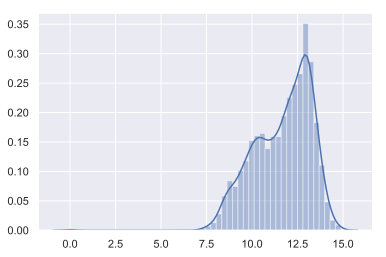

In [23]:
## CHECK missing values of 'air_pollution_particulate_matter_value'
col_name = 'air_pollution_particulate_matter_value'
missing_data_states = list(df_trsc[df_trsc[col_name].isnull()]['state'].unique())
df_trsc[df_trsc['state'].isin(missing_data_states)][id_cols + [col_name, y_label]]

col_values = df_trsc.copy()[col_name].fillna(0).values
gbg_out = sns.distplot(col_values)

In [24]:
## APPLY: Replace missing values of 'air_pollution_particulate_matter_value' with the mean value of total
col_name = 'air_pollution_particulate_matter_value'
gbg_out = gen_fillna(df_trsc, col_name, 'mean')

get_cols_w_missing_data(df_trsc)

Columns with missing data:

Series([], dtype: int64)


(Series([], dtype: int64), [])

### Column Manipulations - I

In [25]:
# APPLY: Change unnecessary 'float' columns to 'int'
for col_name in poss_int_cols_list:
    if np.array_equal(df_trsc[col_name], df_trsc[col_name].astype(int)):
        df_trsc[col_name] = df_trsc[col_name].astype('int64')

In [26]:
df_trsc_2 = df_trsc.copy()
#df_trsc = df_trsc_2.copy()

## Handling Outliers

### 1. Replace 'Percent Value Outliers'

In [27]:
num_cols = list(set(df_train.select_dtypes(include=['int', 'float']).columns) - set(id_cols))

## CHECK: Columns with invalid percent values
pct_col_names = []
for col_name in num_cols:
    if col_name.startswith('pct_'):
        pct_col_names.append(col_name)

srs = df_trsc[(df_trsc[pct_col_names] < 0) | (df_trsc[pct_col_names] > 1)][pct_col_names].count()
srs[srs > 0]

pct_renter_occupied    4966
dtype: int64

In [28]:
## APPLY: Fix 'pct_renter_occupied' column values dividing by 100
df_trsc['pct_renter_occupied'] = df_trsc['pct_renter_occupied'].apply(lambda x: x / 100.0)

### 2. Replace Outliers based on "Deviation"

#### Detecting Outliers

We should detect and handle  the outliers grouping by `state`.

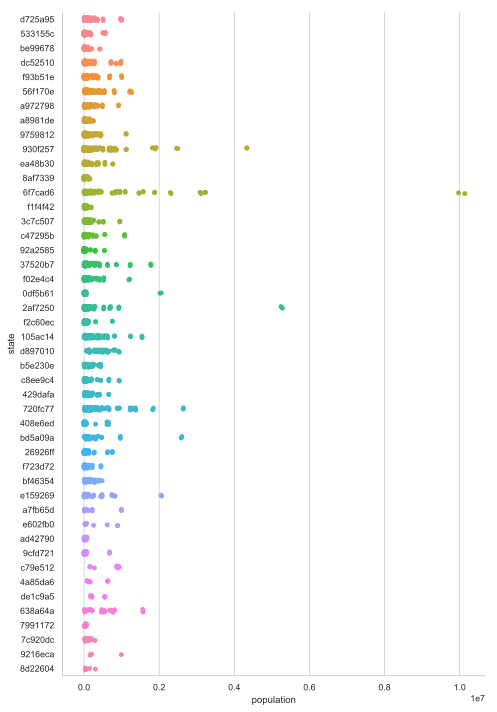

In [29]:
sns.set_style("whitegrid")
sns.set_context("paper")
ax = sns.catplot(data = df_trsc, x = 'population', y = 'state', orient='h', height = 10, aspect=0.7)

In [30]:
num_cols = list(set(df_trsc.select_dtypes(include=['int', 'float']).columns) - set(id_cols))

verbose_output = False
df_by_state = df_trsc.groupby(['state'])
col_names_w_ol = pd.DataFrame(columns=['IQR', 'MAD'])

for col_name in num_cols:
    iqr_outl_states_for_col = detect_iqr_outliers(df_by_state[col_name].mean(), verbose = verbose_output)
    if (verbose_output & (len(iqr_outl_states_for_col) > 0)):
        print('IQR:\n', iqr_outl_states_for_col, '\n')
    
    mad_outl_states_for_col = detect_mad_outliers(df_by_state[col_name].mean(), verbose = verbose_output)
    if (verbose_output & (len(mad_outl_states_for_col) > 0)):
        print('MAD:\n', mad_outl_states_for_col, '\n')
        
    if ((len(iqr_outl_states_for_col) > 0) | (len(mad_outl_states_for_col) > 0)):
        #col_names_w_ol[col_name] = [iqr_outl_states_for_col, mad_outl_states_for_col]  ## Interesting result!
        col_names_w_ol.loc[col_name] = [len(iqr_outl_states_for_col), len(mad_outl_states_for_col)]
    
    if verbose_output:
        print('\n\n')
        
col_names_w_ol

,IQR,MAD
pct_below_18_years_of_age,1,1
renter_occupied_households,3,8
birth_rate_per_1k,2,0
pct_af_am,8,9
pct_hispanic,4,4
pct_am_ind,3,8
pct_multiple,4,3
pct_white,1,1
pct_adults_bachelors_or_higher,3,2
pct_uninsured_children,2,1


### Feature Engineering

Create engineered features (`pop_per_occupied_households` etc.)

In [31]:
## APPLY: Create engineered features (land shares, population shares, etc.)
df_trsc['pop_per_occupied_households'] = df_trsc['population'] / (df_trsc['renter_occupied_households'] / df_trsc['pct_renter_occupied'])

print_df_shape(zip(['Training + Score'], [df_trsc]))

df_trsc[['renter_occupied_households', 'pct_renter_occupied', 'population', 'pop_per_occupied_households']].head()

Training + Score data has 4966 rows and 48 columns. 



,renter_occupied_households,pct_renter_occupied,population,pop_per_occupied_households
0,6944,0.37218,45009,2.412363
1,1224,0.31773,9872,2.562607
2,1725,0.21973,17625,2.245067
3,18180,0.36809,134136,2.715848
4,551,0.17627,6936,2.218891


#### Analyzing Ethnicity

,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other
0,0.412070,0.493459,0.070193,0.002588,0.004575,0.000201,0.015921,0.000993
1,0.838682,0.015588,0.037419,0.073493,0.005771,0.000803,0.028245,0.000000
2,0.873733,0.041040,0.046922,0.004503,0.004873,0.000000,0.028728,0.000200
3,0.264083,0.240836,0.081067,0.377986,0.007244,0.000399,0.025582,0.002804
4,0.924502,0.005146,0.035753,0.014045,0.000707,0.003175,0.016672,0.000000


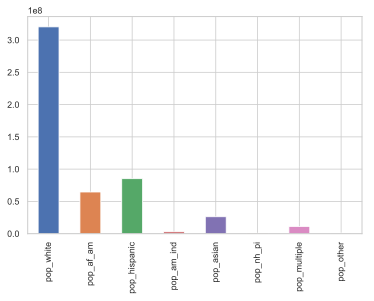

In [32]:
## ANALYZE
df_tmp = df_trsc.copy()

cols_pct_ethnicity = ['pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other']
cols_pop_ethnicity = pd.Series(cols_pct_ethnicity).map(lambda x: 'pop_' + x[4:]).values

for col_pct, col_pop in zip(cols_pct_ethnicity, cols_pop_ethnicity):
    df_tmp[col_pop] = df_tmp['population'] * df_tmp[col_pct]
    
gbg_out = df_tmp[cols_pop_ethnicity].sum().plot.bar()

df_tmp[cols_pct_ethnicity].head()

We can add the values of `'pct_am_ind'`, `'pct_nh_pi'`, `'pct_multiple'` columns to `'pct_other'` and remove those columns.

,pct_af_am,pct_hispanic,pct_white,pct_other,pct_asian
0,0.493459,0.070193,0.412070,0.019703,0.004575
1,0.015588,0.037419,0.838682,0.102540,0.005771
2,0.041040,0.046922,0.873733,0.033432,0.004873
3,0.240836,0.081067,0.264083,0.406771,0.007244
4,0.005146,0.035753,0.924502,0.033892,0.000707


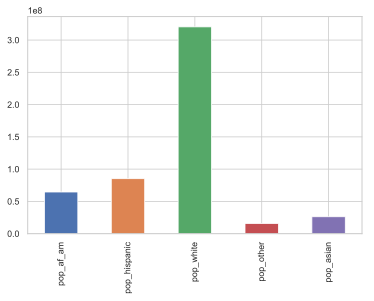

In [33]:
# APPLY (tmp): 
df_tmp = df_trsc.copy()

cols_to_merge = ['pct_am_ind', 'pct_nh_pi', 'pct_multiple'] # 'pct_asian'
df_tmp['pct_other'] = df_tmp[cols_to_merge + ['pct_other']].sum(axis = 1)

df_tmp.drop(columns = cols_to_merge, inplace = True)

# CHECK: 
cols_pct_ethnicity = list(set(cols_pct_ethnicity) - set(cols_to_merge))
cols_pop_ethnicity = pd.Series(cols_pct_ethnicity).map(lambda x: 'pop_' + x[4:]).values

for col_pct, col_pop in zip(cols_pct_ethnicity, cols_pop_ethnicity):
    df_tmp[col_pop] = df_tmp['population'] * df_tmp[col_pct]
    
gbg_out = df_tmp[cols_pop_ethnicity].sum().plot.bar()

df_tmp[cols_pct_ethnicity].head()

In [34]:
# APPLY: 
cols_to_merge = ['pct_am_ind', 'pct_nh_pi', 'pct_multiple'] # 'pct_asian'
df_trsc['pct_other'] = df_trsc[cols_to_merge + ['pct_other']].sum(axis = 1)

df_trsc.drop(columns = cols_to_merge, inplace = True)

print_df_shape(zip(['Training + Score'], [df_trsc]))

Training + Score data has 4966 rows and 45 columns. 



### Column Manipulations

In [35]:
df_trsc_3 = df_trsc.copy()
#df_trsc = df_trsc_2.copy()

#### Encoding `String`type `id` Columns

In [36]:
## CHECK
df_tmp = df_trsc.copy()

# Apply 'Label Encoding' to 'county_code' and 'state' columns
df_tmp['county_code'] = df_tmp['county_code'].astype('category').cat.codes + 1001
df_tmp['state'] = df_tmp['state'].astype('category').cat.codes + 101
df_tmp['year'] = df_tmp['year'].astype('category').cat.codes + 1

df_tmp.dtypes[:4]

row_id         int64
county_code    int16
year            int8
state           int8
dtype: object

In [37]:
## APPLY
df_trsc['county_code'] = df_trsc['county_code'].astype('category').cat.codes + 1001
df_trsc['state'] = df_trsc['state'].astype('category').cat.codes + 101
df_trsc['year'] = df_trsc['year'].astype('category').cat.codes + 1

#### Encoding Categorical Columns

In [38]:
# ANALYZE
non_num_cols = list(set(df_trsc.select_dtypes(include=['object', 'bool']).columns) - set(id_cols))

for col_name in non_num_cols:
    print(df_trsc[col_name].value_counts(), '\n')

## https://www.datacamp.com/community/tutorials/categorical-data 
## Try one-hot encoding for 'economic_topology'
## Try replacing values for 'rucc' and 'urban_influence' with incremental codes
## Try Binary Encoding for 'rucc' and 'urban_influence' which will produce less features

Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area                         913
Metro - Counties in metro areas of 1 million population or more                                  700
Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area                     693
Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area    664
Metro - Counties in metro areas of 250,000 to 1 million population                               573
Metro - Counties in metro areas of fewer than 250,000 population                                 550
Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area        388
Nonmetro - Urban population of 20,000 or more, adjacent to a metro area                          349
Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area                      136
Name: rucc, dtype: int64 

Small-in a metro area with fewer than 1 million residents       

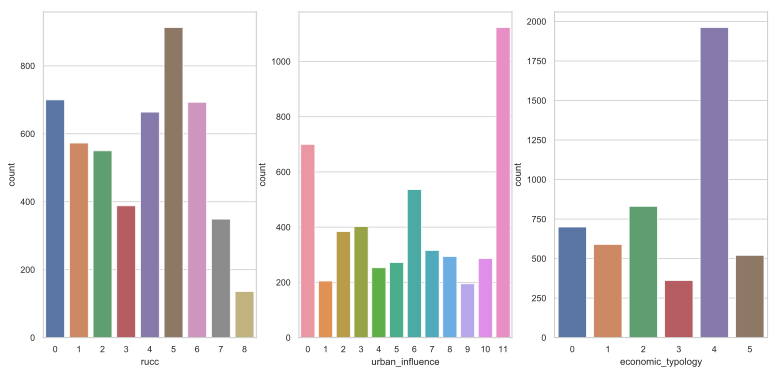

In [39]:
#df_train.where(df_train ['Age']==30)
#%timeit 
## TEST
df_tmp = df_trsc.copy()

f, arr_ax = plt.subplots(1, 3, figsize=(13, 6))

for ndx, col_name in enumerate(non_num_cols):
    df_tmp[col_name] = df_tmp[col_name].astype('category').cat.codes
    sns.countplot(x = col_name, data = df_tmp, ax = arr_ax[ndx])

In [40]:
## APPLY
for ndx, col_name in enumerate(non_num_cols):
    df_trsc[col_name] = df_trsc[col_name].astype('category').cat.codes

#### Transformations

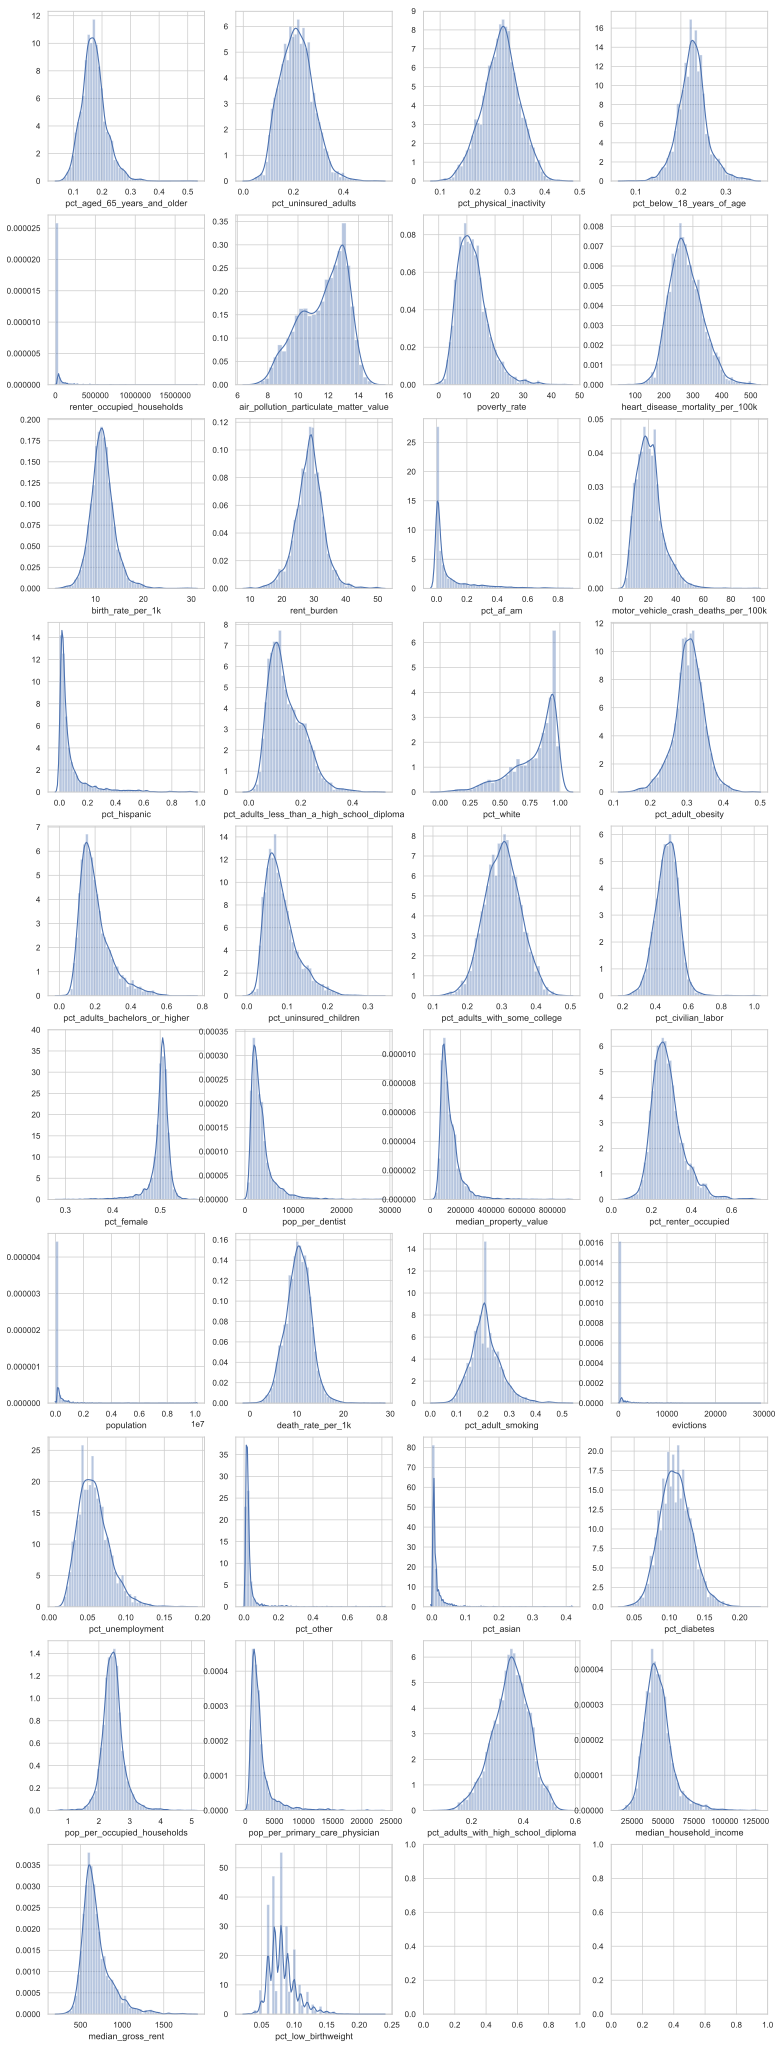

In [41]:
num_cols = list(set(df_trsc.select_dtypes(include=['int', 'float']).columns) - set(id_cols))

plt_col_count = 4
f, arr_ax = plt.subplots(round(len(num_cols) / plt_col_count), plt_col_count, figsize=(14, 40))
for ndx, col_name in enumerate(num_cols):
    rn = int(ndx / plt_col_count)
    cn = ndx % plt_col_count
    sns.distplot(df_trsc[col_name], ax = arr_ax[rn, cn], axlabel=col_name);

In [42]:
from scipy.stats import skew

df_skew = df_trsc[num_cols].apply(skew).sort_values()

print('Positively skewed features:\n\n', df_skew[df_skew > 1], '\n', sep='')
print('Negatively skewed features:\n\n', df_skew[df_skew < -1], '\n', sep='')

Positively skewed features:

motor_vehicle_crash_deaths_per_100k     1.095869
pct_low_birthweight                     1.096619
pct_renter_occupied                     1.120105
poverty_rate                            1.152614
pct_uninsured_children                  1.192765
median_household_income                 1.252594
pct_adults_bachelors_or_higher          1.401814
median_gross_rent                       1.697093
pct_af_am                               2.357426
pop_per_dentist                         3.144441
pct_hispanic                            3.192090
median_property_value                   3.291966
pop_per_primary_care_physician          3.399807
pct_asian                               7.098699
pct_other                               7.307061
evictions                              12.718751
population                             14.503407
renter_occupied_households             16.417748
dtype: float64

Negatively skewed features:

pct_female   -3.140075
pct_white    -1.24253

In [43]:
df_trsc_4 = df_trsc.copy()
#df_trsc = df_trsc_4.copy()

In [44]:
df_trsc['ln_renter_occupied_households'] = np.log(df_trsc['renter_occupied_households'])
df_trsc['ln_population'] = np.log(df_trsc['population'])

df_trsc.drop(columns = ['renter_occupied_households', 'population'], inplace = True)

## Preparing Model
First split back our merged dataset back to TRAIN and SCORE datasets.

In [45]:
## Split back df_trsc in to TRAIN+TEST and SCORE datasets
df_train = df_trsc[df_trsc[y_label] != -1]
df_score = df_trsc[df_trsc[y_label] == -1]

print_df_shape(zip(['Training + Score'], [df_trsc]))
print_df_shape(zip(['Training', 'Score'], [df_train, df_score]))

Training + Score data has 4966 rows and 45 columns. 

Training data has 2546 rows and 45 columns. 

Score data has 2420 rows and 45 columns. 



In [46]:
predictor_lbls = df_train.columns.tolist()
predictor_lbls.remove(y_label)
predictor_lbls.remove(id_col)

df_train_x = df_train[predictor_lbls]
df_train_y = df_train[[y_label]]

### Importing Packages

In [48]:
import xgboost as xgb

from xgboost.sklearn import XGBClassifier
## Additional sklearn functions
from sklearn.model_selection import cross_validate
from sklearn import metrics
## Performing grid search
from sklearn.model_selection import GridSearchCV

## Tuning Parameters

In [63]:
tuning_disabled = False  ## Usage: %%skip $tuning_disabled

def model_fit_xgb(alg, dtrain, predictor_lbls, target_lbl, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    df_x = dtrain[predictor_lbls]
    df_y = dtrain[target_lbl]
    
    if useTrainCV:
        xgb_params = alg.get_xgb_params()
        
        #dm_train = xgb.DMatrix(df_x.values, label = df_y.values)
        dm_train = xgb.DMatrix(df_x, label = df_y)
        
        cv_results = xgb.cv(xgb_params,
                            dm_train,
                            num_boost_round = alg.get_params()['n_estimators'],
                            nfold = cv_folds,
                            # stratified = True, # makes the result worse
                            
                            metrics = 'rmse',
                            early_stopping_rounds = early_stopping_rounds)
        
        opt_num_boost_round = cv_results.shape[0]
        
        print('Optimum num_boost_round: ', opt_num_boost_round, '\n', cv_results.tail(1))
        alg.set_params(n_estimators = opt_num_boost_round)
        print('\n','get_xgb_params:', alg.get_xgb_params())
        #print('\n','get_params:', alg.get_params())
    

    #Fit the algorithm on the data
    %timeit alg.fit(df_x, df_y, eval_metric = 'rmse', verbose = True)
        
    #Predict training set:
    df_y_pred = alg.predict(df_x)
        
    #Print model report:
    print('\nModel Report')
    print('RMSE : %.2f' % metrics.mean_squared_error(df_y, df_y_pred))
    print('R2 Score (Train): %f' % metrics.r2_score(df_y, df_y_pred))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    
    feat_imp.plot(kind='bar', title = 'Feature Importances')
    plt.ylabel('Feature Importance Score')


## General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

1. Choose a relatively **high `learning rate`**. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as `“cv”` which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. Tune **tree-specific parameters** ( `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and we’ll take up an example here.
3. Tune **regularization parameters** (`lambda`, `alpha``) for xgboost which can help reduce model complexity and enhance performance.
4. **Lower the `learning rate``** and decide the optimal parameters.

### Step 1: Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1. max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
2. min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
3. gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
4. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
5. scale_pos_weight = 1: Because of high class imbalance.


Please note that all the above are just *initial estimates* and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

Optimum num_boost_round:  49 
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
48       134.544153        4.844269        468.4789     197.599291

 get_xgb_params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 49, 'nthread': 4, 'objective': 'reg:linear', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 123, 'silent': 1, 'subsample': 0.8}
414 ms ± 6.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Model Report
RMSE : 17350.75
R2 Score (Train): 0.991210


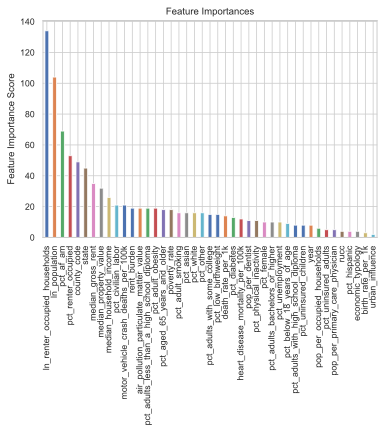

In [64]:
%%skip $tuning_disabled

## Choose all predictors except target & IDcols to fit a model

xgb_01 = xgb.XGBRegressor(
    objective = 'reg:linear',
    
    n_estimators = 1000,
    
    learning_rate = 0.1,
    
    max_depth = 5,
    min_child_weight = 1,
    
    gamma = 0,
    
    subsample = 0.8,
    colsample_bytree = 0.8,
    nthread = 4,
    scale_pos_weight = 1,
    seed = 123
)

model_fit_xgb(xgb_01, df_train, predictor_lbls, target_lbl = y_label)

### Step 2: Tune `max_depth` and `min_child_weight`

We tune these first as they will have the **highest impact** on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

**Important Note:** We’ll be doing some `heavy-duty` grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

In [65]:
%%skip $tuning_disabled

param_test_01 = {
 'max_depth': range(3, 10, 2), # [3, 5, 7, 9]
 'min_child_weight': range(1, 6, 2) # [1, 3, 5]
}

gsearch_01 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 5,
        min_child_weight = 1, 

        gamma = 0,
        
        subsample = 0.8,
        colsample_bytree = 0.8,
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_01, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_01.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_01.best_score_, gsearch_01.best_params_))

Best Score (r2): 0.891995, Best Params: {'max_depth': 7, 'min_child_weight': 1}


Here, we have run with wider intervals between values.
> The ideal values are `max_depth: 7` and 1 `min_child_weight: 1`.

Let's go one step deeper and look for optimum values. We’ll search for values 1 above and 1 below the optimum values because we took an interval of 2.

In [66]:
%%skip $tuning_disabled

param_test_02 = {
 'max_depth': [6, 7, 8],
 'min_child_weight': [0, 1, 2]
}

gsearch_02 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 5,
        min_child_weight = 1, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.8,
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_02, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_02.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_02.best_score_, gsearch_02.best_params_))

Best Score (r2): 0.891995, Best Params: {'max_depth': 7, 'min_child_weight': 0}


As we see, `max_depth` didn't improve further, but `min_child_weight` decreased to `0`.
> Their optimum values: `'max_depth': 7, 'min_child_weight': 0`

### Step 2: Tune `gamma`

No we will tune `gamma` value using the parameters already tuned above. `Gamma` can take **various** values but we’ll check for *5 values* here. You can go into more precise values as.

In [67]:
%%skip $tuning_disabled

param_test_03 = {
 'gamma': [i/10.0 for i in range(0, 5)]
}

gsearch_03 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 7,
        min_child_weight = 0, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.8,
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_03, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_03.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_03.best_score_, gsearch_03.best_params_))

Best Score (r2): 0.891995, Best Params: {'gamma': 0.0}


This shows that our original value of `gamma: 0` is the optimum one.

Before proceeding, a good idea would be to **re-calibrate** the number of **boosting rounds** for the updated parameters.

Optimum num_boost_round:  49 
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
48        90.257318       11.179703      468.295056     200.194164

 get_xgb_params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0, 'missing': None, 'n_estimators': 49, 'nthread': 4, 'objective': 'reg:linear', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 123, 'silent': 1, 'subsample': 0.8}
566 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Model Report
RMSE : 7239.78
R2 Score (Train): 0.996332


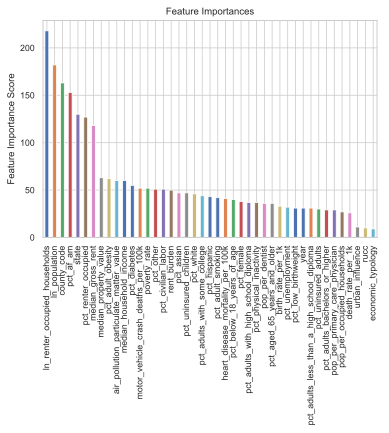

In [68]:
%%skip $tuning_disabled

xgb_02 = xgb.XGBRegressor(
    objective = 'reg:linear',
    
    n_estimators = 1000,
    
    learning_rate = 0.1,
    
    max_depth = 7,
    min_child_weight = 0,
    
    gamma = 0,
    
    subsample = 0.8,
    colsample_bytree = 0.8,
    
    nthread = 4,
    scale_pos_weight = 1,
    seed = 123
)

model_fit_xgb(xgb_02, df_train, predictor_lbls, target_lbl = y_label)

## Previous score
## RMSE : 17350.75
## R2 Score (Train): 0.991210

Our `R2 score` increased a little and alsoe `RMSE` decreased quite nicely. On the other hand, `num_boost_round` didn't change.

So far the final parameters are:

- `num_boost_round`: 49
- `max_depth`: 7
- `min_child_weight`: 0
- `gamma`: 0

### Step 4: Tune `subsample` and `colsample_bytree`

The next step would be try different `subsample` and `colsample_bytree` values. We will do this in *2 stages* as well and take values `0.6,0.7,0.8,0.9` for both to start with.

In [69]:
%%skip $tuning_disabled

param_test_04 = {
 'subsample': [i / 10.0 for i in range(6, 10)],         ## [0.6, 0.7, 0.8, 0.9]
 'colsample_bytree': [i / 10.0 for i in range(6, 10)]   ## [0.6, 0.7, 0.8, 0.9]
}

gsearch_04 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 7,
        min_child_weight = 0, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.8,
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_04, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_04.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_04.best_score_, gsearch_04.best_params_))

Best Score (r2): 0.894720, Best Params: {'colsample_bytree': 0.9, 'subsample': 0.8}


Here, we found `'colsample_bytree': 0.9` and `'subsample': 0.8` as the optimum values Now we should try values in **0.05** interval around these.

In [70]:
%%skip $tuning_disabled

param_test_05 = {
 'subsample': [i / 100.0 for i in range(75, 90, 5)],         ## [0.75, 0.8, 0.85]
 'colsample_bytree': [i / 100.0 for i in range(85, 105, 5)]  ## [0.85, 0.9, 0.95, 1.0]
}

gsearch_05 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 7,
        min_child_weight = 0, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.8,
        
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_05, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_05.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_05.best_score_, gsearch_05.best_params_))

Best Score (r2): 0.895207, Best Params: {'colsample_bytree': 0.95, 'subsample': 0.8}


`'subsample'` didn't change, but `'colsample_bytree'` increased.

>Final optimum values are: `'colsample_bytree': 0.95, 'subsample': 0.8`

### Step 5: Tuning Regularization Parameters (To reduce overfitting)

Next step is to apply **regularization** to reduce overfitting. Though many people don’t use this parameters much as `gamma` provides a substantial way of controlling complexity. But we should always try it. 

We’ll tune `'reg_alpha'` and `'reg_lambda'`.

In [71]:
%%skip $tuning_disabled

param_test_06 = {
 'reg_alpha': [0.01, 0.1, 1, 10, 100],
 'reg_lambda': [0.01, 0.1, 1, 10, 100]
}

gsearch_06 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 7,
        min_child_weight = 0, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.95,
        
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_06, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_06.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_06.best_score_, gsearch_06.best_params_))

Best Score (r2): 0.895349, Best Params: {'reg_alpha': 0.1, 'reg_lambda': 1}


We can see that the **CV score** is *higher* than the previous case. `'reg_lambda'` didn't change from `default = 1`, but `'reg_alpha'` decreased to 0.1 from `default = 1`.

The values we tried were very widespread, so now we should try values closer to the optimum of `'reg_alpha'`, which is 0.1, to see if we get something better.

In [72]:
%%skip $tuning_disabled

param_test_07 = {
 'reg_alpha': [0.005, 0.1, 0.15, 0.2, 0.3],
 'reg_lambda': [0.5, 0.6, 0.8, 1, 1.05, 1.1]
}

gsearch_07 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 7,
        min_child_weight = 0, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.95,
        
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_07, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_07.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_07.best_score_, gsearch_07.best_params_))

Best Score (r2): 0.896613, Best Params: {'reg_alpha': 0.3, 'reg_lambda': 1}


Again, `'reg_lambda'` didn't change from `default = 1`, but `'reg_alpha'` increased from 0.1 to 0.3. It might have a tendency to be a higher value. So now we can just tune `'reg_alpha'` between 0.3 and 1.

In [73]:
%%skip $tuning_disabled

param_test_08 = {
 'reg_alpha': np.round(np.arange(0.3, 1, 0.1), 2)  ## [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

gsearch_08 = GridSearchCV(
    estimator = xgb.XGBRegressor(
        objective = 'reg:linear',
        n_estimators = 49,

        learning_rate = 0.1,

        max_depth = 7,
        min_child_weight = 0, 

        gamma = 0,
        
        subsample = 0.8, 
        colsample_bytree = 0.95,
        
        nthread = 4,
        scale_pos_weight = 1,
        seed = 123
    ),
    param_grid = param_test_08, 
    scoring = 'r2', n_jobs = 4, iid = False, cv = 5)

gsearch_08.fit(df_train[predictor_lbls], df_train[y_label])

print('Best Score (r2): %f, Best Params: %s' % (gsearch_08.best_score_, gsearch_08.best_params_))

Best Score (r2): 0.896837, Best Params: {'reg_alpha': 0.4}


Yes, our `'reg_alpha'` increased from 0.3 to 0.4 and our **CV score** also increased a little.

Now we can apply this regularization in the model and look at the impact:

Optimum num_boost_round:  43 
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
42       113.108336        9.998452      479.423083     210.813179

 get_xgb_params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0, 'missing': None, 'n_estimators': 43, 'nthread': 4, 'objective': 'reg:linear', 'reg_alpha': 0.4, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 123, 'silent': 1, 'subsample': 0.8}
572 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Model Report
RMSE : 10897.07
R2 Score (Train): 0.994480


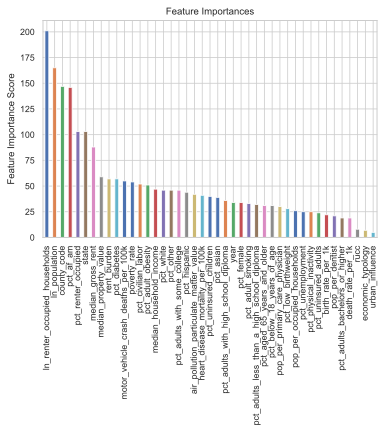

In [74]:
%%skip $tuning_disabled

xgb_03 = xgb.XGBRegressor(
    objective = 'reg:linear',
    
    n_estimators = 1000,
    
    learning_rate = 0.1,
    
    max_depth = 7,
    min_child_weight = 0,
    
    gamma = 0,
    
    subsample = 0.8,
    colsample_bytree = 0.95,
    
    reg_alpha = 0.4,
    
    nthread = 4,
    scale_pos_weight = 1,
    seed = 123
)

model_fit_xgb(xgb_03, df_train, predictor_lbls, target_lbl = y_label)

## Previous score
## RMSE : 7239.78
## R2 Score (Train): 0.996332

Our `R2 score` changed agin increased a little, but this time `RMSE` increased. On the other hand, `num_boost_round` didn't change.

### Step 6: Reducing Learning Rate

Lastly, we should **lower** the learning rate and add more trees. We will use the `cv` function of `XGBoost` to do the job again.

Optimum num_boost_round:  441 
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
440       108.388202        6.922594      448.158081     192.477298

 get_xgb_params: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.95, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0, 'missing': None, 'n_estimators': 441, 'nthread': 4, 'objective': 'reg:linear', 'reg_alpha': 0.4, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 123, 'silent': 1, 'subsample': 0.8}
5.89 s ± 58.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Model Report
RMSE : 9721.88
R2 Score (Train): 0.995075


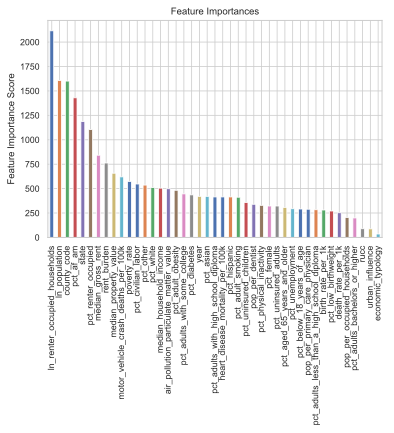

In [75]:
%%skip $tuning_disabled

xgb_04 = xgb.XGBRegressor(
    objective = 'reg:linear',
    
    n_estimators = 5000,
    
    learning_rate = 0.01,
    
    max_depth = 7,
    min_child_weight = 0,
    
    gamma = 0,
    
    subsample = 0.8,
    colsample_bytree = 0.95,
    
    reg_alpha = 0.4,
    
    nthread = 4,
    scale_pos_weight = 1,
    seed = 123
)

model_fit_xgb(xgb_04, df_train, predictor_lbls, target_lbl = y_label)

## Previous score
## RMSE : 10897.07
## R2 Score (Train): 0.994480

Now we can see a significant boost in performance and the effect of parameter tuning is clearer.

As we come to the end, I would like to share *two* key thoughts:

1. It is difficult to get a very big leap in performance by just using parameter tuning or slightly better models.

2. A significant jump can be obtained by other methods like *feature engineering*, *creating ensemble of models*, *stacking*, etc

5.84 s ± 65.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Model Report
RMSE : 9721.88
R2 Score (Train): 0.995075


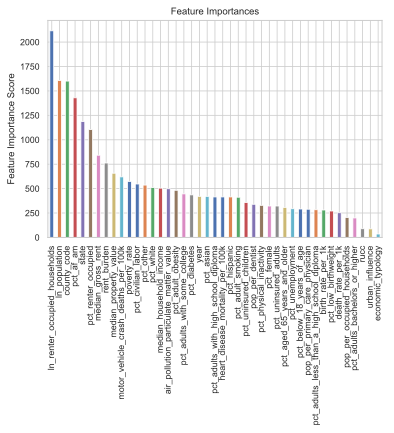

In [76]:
xgb_Final = xgb.XGBRegressor(
    objective = 'reg:linear',
    
    n_estimators = 441,
    
    learning_rate = 0.01,
    
    max_depth = 7,
    min_child_weight = 0,
    
    gamma = 0,
    
    subsample = 0.8,
    colsample_bytree = 0.95,
    
    reg_alpha = 0.4,
    
    nthread = 4,
    scale_pos_weight = 1,
    seed = 123
)

model_fit_xgb(xgb_Final, df_train, predictor_lbls, target_lbl = y_label, useTrainCV = False)

## Previous score
## RMSE : 9721.88
## R2 Score (Train): 0.995075

# Make Prediction

In [81]:
df_score_x = df_score[predictor_lbls]
preds = xgb_Final.predict(df_score_x)

In [110]:
df_preds = pd.DataFrame({ 'row_id': df_score[id_col], 'evictions': preds })
df_preds['evictions'] = round(df_preds['evictions']).astype(int)

df_preds.head()

df_preds.to_csv('submission_01.csv')

,row_id,evictions
2546,0,1143
2547,1,245
2548,2,5
2549,3,14
2550,4,204


In [108]:
df_tmp = pd.DataFrame({ 'row_id': df_score[id_col], 'evictions': preds })
df_tmp['evictions_rnd'] = round(df_tmp['evictions']).astype(int)
df_tmp['evictions_int'] = df_tmp['evictions'].astype(int)

df_tmp.head()

df_tmp.apply(lambda x: abs(x['evictions_rnd'] - x['evictions_int']), axis = 1).sum()

,row_id,evictions,evictions_rnd,evictions_int
2546,0,1142.888672,1143,1142
2547,1,244.794952,245,244
2548,2,4.614332,5,4
2549,3,13.933137,14,13
2550,4,204.218277,204,204


1178.0

# Submission 01 - Public R2 Score: 0.8145